In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR


os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

size = 128
batch_size = 1
device = 'cuda:0'

root_train = "C://Users//96224//PycharmProjects//gagarin_hack//datasets//data_after_seg//train"
root_valid = "C://Users//96224//PycharmProjects//gagarin_hack//datasets//data_after_seg//valid"

In [2]:
TRANSFORM = transforms.Compose([transforms.Grayscale(),
                                transforms.Resize([size, size]),
                                transforms.ToTensor()])

data_train = torchvision.datasets.ImageFolder(root_train, TRANSFORM)
data_valid = torchvision.datasets.ImageFolder(root_valid, TRANSFORM)

In [3]:
mean, std = 0, 0
for data in data_train:
    mean += data[0].mean([1, 2])
    std += data[0].std([1, 2])

for data in data_valid:
    mean += data[0].mean([1, 2])
    std += data[0].std([1, 2])

mean /= (len(data_train) + len(data_valid))
std /= (len(data_train) + len(data_valid))

In [4]:
mean, std, data_train[1][0].min(), data_train[1][0].max()

(tensor([0.6914]), tensor([0.1212]), tensor(0.3451), tensor(1.))

In [5]:
TRANSFORM = transforms.Compose([transforms.Grayscale(),
                                transforms.Resize([size, size]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

TRANSFORM_AU1 = transforms.Compose([transforms.Grayscale(),
                                   transforms.Resize([int(1.3 * size), int(1.3 * size)]),
                                   transforms.RandomRotation([90, 90]),
                                   transforms.RandomCrop(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean, std)])

TRANSFORM_AU2 = transforms.Compose([transforms.Grayscale(),
                                   transforms.Resize([int(1.3 * size), int(1.3 * size)]),
                                   transforms.RandomRotation([180, 180]),
                                   transforms.RandomCrop(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean, std)])

TRANSFORM_AU3 = transforms.Compose([transforms.Grayscale(),
                                   transforms.Resize([int(1.3 * size), int(1.3 * size)]),
                                   transforms.RandomRotation([270, 270]),
                                   transforms.RandomCrop(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean, std)])

data_train = torchvision.datasets.ImageFolder(root_train, TRANSFORM)
data_valid = torchvision.datasets.ImageFolder(root_valid, TRANSFORM)

for i in range(1):
    data_train += torchvision.datasets.ImageFolder(root_train, TRANSFORM_AU1)
    data_train += torchvision.datasets.ImageFolder(root_train, TRANSFORM_AU2)    
    data_train += torchvision.datasets.ImageFolder(root_train, TRANSFORM_AU3)    

In [6]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, shuffle=True)

print("Кол-во батчей train =", len(train_loader))
print("Кол-во батчей valid =", len(valid_loader))

Кол-во батчей train = 520
Кол-во батчей valid = 49


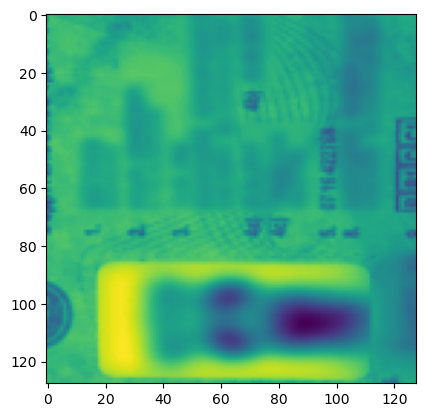

In [7]:
plt.imshow(data_train[130][0].reshape(128, 128, 1))

In [8]:
model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(in_features=512, out_features=6, bias=True)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [9]:
#model.load_state_dict(torch.load("model_class", weights_only=True))
#model.to(device)
#print("Кол-во параметров = ", sum(p.numel() for p in model.parameters() if p.requires_grad))

In [10]:
accuracy_memory = [0]

model = model.to(device)
best_model = model

print("Кол-во параметров = ", sum(p.numel() for p in model.parameters() if p.requires_grad))

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

lambda1 = lambda epoch: 0.98 ** epoch
scheduler = LambdaLR(optimizer, lr_lambda=lambda1)

for epoch in tqdm(range(100)):
    accuracy_list = []

    for batch in train_loader:
        optimizer.zero_grad()
        images = batch[0]
        targets = batch[1]
        preds = model.forward(images.to(device))

        loss_batch = loss(preds, targets.to(device))

        loss_batch.backward()
        optimizer.step()
        
        accuracy_batch = (preds.argmax(dim=1) == targets.to(device)).float().mean()
        accuracy_list.append(accuracy_batch.item())

    accuracy = (sum(accuracy_list) / len(accuracy_list))
    print(f"Точность тренировки {epoch + 1} эпохи = ", accuracy * 100, "%", sep="")
    accuracy, items_count = 0, 0

    classes = data_valid.classes
    errors_dict = {}
    for name in classes:
        errors_dict[name] = 0
    for batch in valid_loader:
        with torch.no_grad():
            images = batch[0]
            targets = batch[1]
            preds = model.forward(images.to(device))
            for i in range(len(preds.argmax(dim=1))):
                if preds.argmax(dim=1)[i] != targets[i].to(device):
                    errors_dict[classes[targets[i]]] += 1
                else:
                    accuracy += 1
                items_count += 1

    accuracy = (accuracy / items_count)
    if accuracy > max(accuracy_memory):
        best_model = model
    accuracy_memory.append(accuracy)
    scheduler.step()
    print(f"Точность валидации {epoch + 1} эпохи = ", accuracy * 100, "%", sep="")
    
    #print(errors_dict)

Кол-во параметров =  11173318


  0%|   | 0/10 [00:00<?, ?it/s]

Точность тренировки 1 эпохи = 32.69230769230769%


 10%| | 1/10 [00:19<02:53, 19.2

Точность валидации 1 эпохи = 48.97959183673469%
Точность тренировки 2 эпохи = 44.80769230769231%


 20%|▏| 2/10 [00:40<02:44, 20.5

Точность валидации 2 эпохи = 48.97959183673469%
Точность тренировки 3 эпохи = 68.84615384615384%


 30%|▎| 3/10 [01:01<02:26, 20.8

Точность валидации 3 эпохи = 65.3061224489796%
Точность тренировки 4 эпохи = 73.26923076923076%


 40%|▍| 4/10 [01:23<02:07, 21.1

Точность валидации 4 эпохи = 71.42857142857143%
Точность тренировки 5 эпохи = 79.61538461538461%


 50%|▌| 5/10 [01:45<01:46, 21.3

Точность валидации 5 эпохи = 73.46938775510205%
Точность тренировки 6 эпохи = 82.11538461538461%


 60%|▌| 6/10 [02:06<01:25, 21.3

Точность валидации 6 эпохи = 83.6734693877551%
Точность тренировки 7 эпохи = 87.5%


 70%|▋| 7/10 [02:27<01:03, 21.3

Точность валидации 7 эпохи = 81.63265306122449%


 70%|▋| 7/10 [02:29<01:04, 21.4


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import matplotlib.pyplot as plt

plt.plot(accuracy_memory)

In [263]:
max(accuracy_memory)

0.7291666666666666

In [271]:
torch.save(best_model.state_dict(), "model_class")

In [264]:
errors_dict = {}
accuracy = 0
items_count = 0
for name in classes:
    errors_dict[name] = 0

for batch in valid_loader:
    with torch.no_grad():
        images = batch[0]
        targets = batch[1]
        preds = best_model.forward(images.to(device))
        for i in range(len(preds.argmax(dim=1))):
            if preds.argmax(dim=1)[i] != targets[i].to(device):
                errors_dict[classes[targets[i]]] += 1
            else:
                accuracy += 1
            items_count += 1

In [265]:
accuracy / items_count

0.875

In [266]:
errors_dict

{'DRIVERS_SIDE_1': 0,
 'DRIVERS_SIDE_2': 1,
 'PASSPORT_SIDE_1': 0,
 'PASSPORT_SIDE_2': 2,
 'STS_SIDE_1': 2,
 'STS_SIDE_2': 1}

In [267]:
data_valid.classes

['DRIVERS_SIDE_1',
 'DRIVERS_SIDE_2',
 'PASSPORT_SIDE_1',
 'PASSPORT_SIDE_2',
 'STS_SIDE_1',
 'STS_SIDE_2']

In [268]:
data_valid_test = torchvision.datasets.ImageFolder("need_predict", TRANSFORM)
valid_loader_test = torch.utils.data.DataLoader(data_valid_test, batch_size=batch_size, shuffle=True)

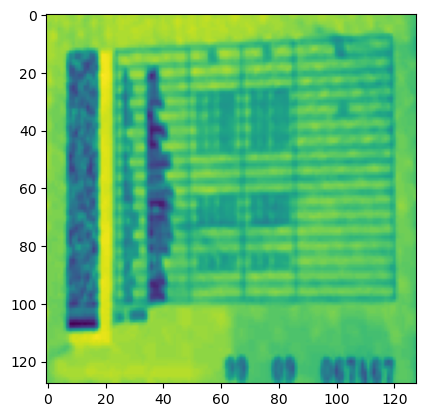

In [269]:
plt.imshow(data_valid_test[0][0].reshape(128, 128, 1))

In [270]:
with torch.no_grad():
    for data in valid_loader_test:
        print(model.forward(data[0].to(device)).argmax(dim=1))

tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([4], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
